<a href="https://colab.research.google.com/github/VKSi/2021_07_GB_ComputerVision/blob/main/HW_3_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

Обучить СНС с помощью Transfer Learning на датасете Food-101
Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.
Библиотеки: [Python, Tensorflow]

## Переключение версии TensorFlow

In [ ]:
%tensorflow_version 2.x

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка датасета Food101
https://www.tensorflow.org/datasets/catalog/food101

In [ ]:
tfds.disable_progress_bar()
ds, info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteAN09A5/food101-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteAN09A5/food101-validation.tfrecord
Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
info

tfds.core.DatasetInfo(
    name='food101',
    version=2.0.0,
    description='This dataset consists of 101 food categories, with 101'000 images. For each class, 250 manually reviewed test images are provided as well as 750 training images. On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.',
    homepage='https://www.vision.ee.ethz.ch/datasets_extra/food-101/',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
    }),
    total_num_examples=101000,
    splits={
        'train': 75750,
        'validation': 25250,
    },
    supervised_keys=('image', 'label'),
    citation="""@inproceedings{bossard14,
      title = {Food-101 -- Mining Discriminative Components with Random Forests},
      

In [ ]:
train_ds, test_ds = ds['train'], ds['validation']

## Визуализация датасета Food101

Попробовал три способа визуализации данных

,image,label
0,,56 (huevos_rancheros)
1,,76 (pizza)
2,,21 (chocolate_cake)
3,,64 (miso_soup)

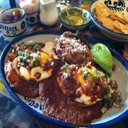
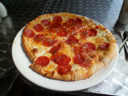
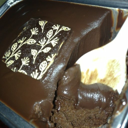
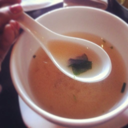

In [ ]:
tfds.as_dataframe(train_ds.take(4), info)

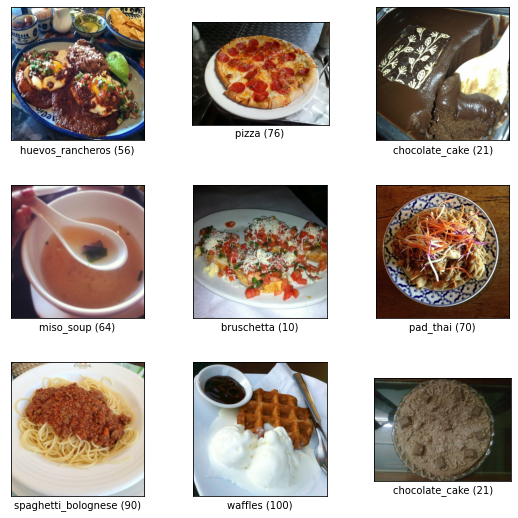

In [ ]:
fig = tfds.show_examples(train_ds, info)

In [ ]:
get_label_name = info.features['label'].int2str
get_label_name(0)

'apple_pie'

In [ ]:
some_labels = [get_label_name(x) for x in range(5)]
some_labels

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [ ]:
some_samples = [x[0] for x in iter(train_ds.take(32))]
some_lables = [get_label_name(x[1]) for x in iter(train_ds.take(32))]

fig = plt.figure(figsize=(16, 8))
for j in range(len(some_samples)):
    ax = fig.add_subplot(4, 8, j+1)
    ax.title.set_text(some_lables[j])
    ax.imshow(some_samples[j])
    plt.xticks([]), plt.yticks([])
plt.show()

## Создание пайплайна данных

In [ ]:
INP_SIZE = 160
NUM_EPOCHS = 10
BATCH_SIZE = 32
NUM_CLASSES = info.features['label'].num_classes

In [ ]:
def prepare(img, label, n_classes=NUM_CLASSES):
    img = tf.cast(img, tf.float32)/127. - 1.
    return tf.image.resize(img, (INP_SIZE, INP_SIZE)), label

In [ ]:
train_ds = train_ds.map(prepare)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

# Подготовка модели CNN

In [ ]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(INP_SIZE, INP_SIZE, 3),
    include_top=False,
    weights='imagenet',
)
base_model.trainable = True # Fine-tuning весов предобученной модели
# base_model.trainable = False # Заморозка весов предобученной модели

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(101, activation='softmax'),
])

## Подготовка к обучению

In [ ]:
LEARNING_RATE = 0.0001
optimizer = tf.keras.optimizers.RMSprop(learning_rate=LEARNING_RATE)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/', 
    write_graph=False, update_freq=100, profile_batch=0)

## Model Summary

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 101)               129381    
Total params: 2,387,365
Trainable params: 2,353,253
Non-trainable params: 34,112
_________________________________________________________________


## Обучение модели

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
PATH = 'gdrive/My Drive/AI/GB/CV/'
PATH_L3 = PATH + 'Lesson3/'
CPS_PATH = PATH_L3 + 'CPS/'

In [ ]:
checkpoint_path = CPS_PATH + "training_1/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

### !!! Ячейку ниже не запускать при повторном запуске ноутбука !!!

In [ ]:
%%time

history = model.fit(
    train_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback, cp_callback])

Epoch 1/10
2367/2367 [==============================] - 503s 196ms/step - loss: 2.0489 - accuracy: 0.4968 - val_loss: 1.3766 - val_accuracy: 0.6320

Epoch 00001: saving model to gdrive/My Drive/AI/GB/CV/Lesson3/CPS/training_1/cp.ckpt
Epoch 2/10
2367/2367 [==============================] - 485s 202ms/step - loss: 1.1808 - accuracy: 0.6881 - val_loss: 1.2142 - val_accuracy: 0.6776

Epoch 00002: saving model to gdrive/My Drive/AI/GB/CV/Lesson3/CPS/training_1/cp.ckpt
Epoch 3/10
2367/2367 [==============================] - 498s 208ms/step - loss: 0.8424 - accuracy: 0.7706 - val_loss: 1.2646 - val_accuracy: 0.6821

Epoch 00003: saving model to gdrive/My Drive/AI/GB/CV/Lesson3/CPS/training_1/cp.ckpt
Epoch 4/10
2367/2367 [==============================] - 473s 199ms/step - loss: 0.6032 - accuracy: 0.8296 - val_loss: 1.4217 - val_accuracy: 0.6658

Epoch 00004: saving model to gdrive/My Drive/AI/GB/CV/Lesson3/CPS/training_1/cp.ckpt
Epoch 5/10
2367/2367 [==============================] - 474s 199

## Оценка качества модели

In [ ]:
%%time

model.evaluate(test_ds)

197/197 [==============================] - 57s 283ms/step - loss: 2.0506 - accuracy: 0.6561
CPU times: user 1min 43s, sys: 4.88 s, total: 1min 48s
Wall time: 1min 21s


[2.0506200790405273, 0.6561310291290283]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## Аугументация данных и дообучение на них

https://www.tensorflow.org/tutorials/images/data_augmentation     
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator     
https://www.kdnuggets.com/2020/02/easy-image-dataset-augmentation-tensorflow.html


In [ ]:
train_ds, test_ds = ds['train'], ds['validation']

,image,label
0,,29 (cup_cakes)
1,,81 (ramen)
2,,91 (spaghetti_carbonara)
3,,53 (hamburger)

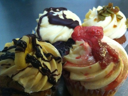
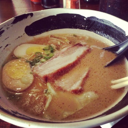
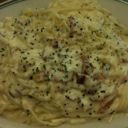
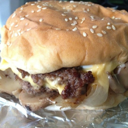

In [ ]:
tfds.as_dataframe(test_ds.take(4), info)

,image,label
0,,56 (huevos_rancheros)
1,,76 (pizza)
2,,21 (chocolate_cake)
3,,64 (miso_soup)

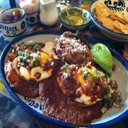
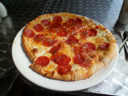
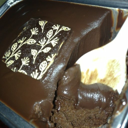
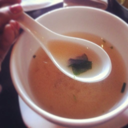

In [ ]:
tfds.as_dataframe(train_ds.take(4), info)

In [ ]:
from tensorflow.keras import layers

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

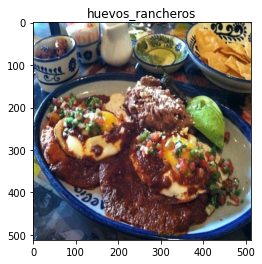

In [ ]:
image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

In [ ]:
image = tf.expand_dims(image, 0)

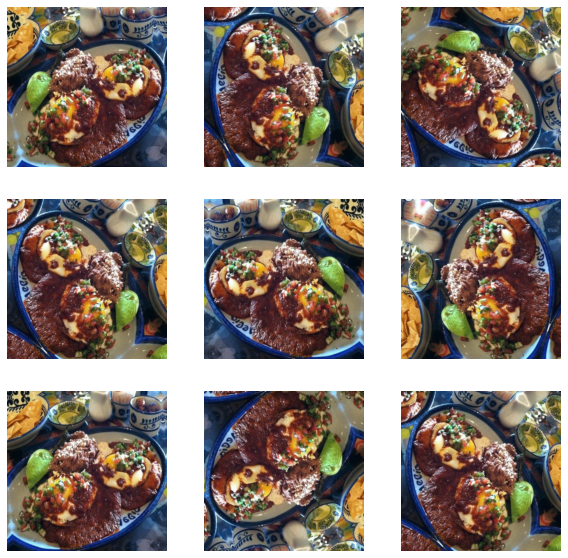

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

In [ ]:
train_ds = train_ds.map(prepare)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = test_ds.shuffle(buffer_size=1000)
test_ds = test_ds.map(prepare)
test_ds = test_ds.batch(128, drop_remainder=True)

In [ ]:
image, label = next(iter(train_ds))
image.shape

TensorShape([32, 160, 160, 3])

In [ ]:
aug_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [ ]:
image, label = next(iter(aug_ds))
image.shape

TensorShape([32, 160, 160, 3])

In [ ]:
image, label = next(iter(test_ds))
image.shape

TensorShape([128, 160, 160, 3])

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/augumented/', 
    write_graph=False, update_freq=100, profile_batch=0)

In [ ]:
checkpoint_path = CPS_PATH + "training_2/cp.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [ ]:
history = model.fit(
    aug_ds,
    epochs=NUM_EPOCHS,
    validation_data=test_ds,
    callbacks=[tensorboard_callback, cp_callback])

Epoch 1/10
2367/2367 [==============================] - 994s 415ms/step - loss: 2.3104 - accuracy: 0.4394 - val_loss: 1.6775 - val_accuracy: 0.5622

Epoch 00001: saving model to gdrive/My Drive/AI/GB/CV/Lesson3/CPS/training_2/cp.ckpt
Epoch 2/10
2367/2367 [==============================] - 974s 410ms/step - loss: 1.5698 - accuracy: 0.5941 - val_loss: 1.8876 - val_accuracy: 0.5299

Epoch 00002: saving model to gdrive/My Drive/AI/GB/CV/Lesson3/CPS/training_2/cp.ckpt
Epoch 3/10
2367/2367 [==============================] - 964s 406ms/step - loss: 1.3649 - accuracy: 0.6401 - val_loss: 1.6219 - val_accuracy: 0.5829

Epoch 00003: saving model to gdrive/My Drive/AI/GB/CV/Lesson3/CPS/training_2/cp.ckpt
Epoch 4/10
2367/2367 [==============================] - 988s 416ms/step - loss: 1.2349 - accuracy: 0.6717 - val_loss: 1.5992 - val_accuracy: 0.6093

Epoch 00004: saving model to gdrive/My Drive/AI/GB/CV/Lesson3/CPS/training_2/cp.ckpt
Epoch 5/10
2367/2367 [==============================] - 966s 407

## TensorBoard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

## Запуск предсказания на нашем изображении

--2021-06-13 20:20:13--  https://raw.githubusercontent.com/dkorobchenko-nv/dl-demo/master/catdog/img/image.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824547 (805K) [image/png]
Saving to: ‘image.png’

image.png           100%[===================>] 805.22K  --.-KB/s    in 0.07s   

2021-06-13 20:20:14 (12.1 MB/s) - ‘image.png’ saved [824547/824547]



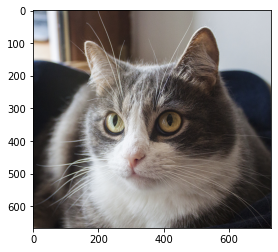

In [ ]:
import imageio
from skimage.transform import resize

def prepare_image(img):
    img = img.astype(np.float32)/127. - 1.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img.astype(np.float32)

if 1:
    !wget https://raw.githubusercontent.com/dkorobchenko-nv/dl-demo/master/catdog/img/image.png

img = imageio.imread('image.png', pilmode="RGB")
plt.imshow(img)
img = prepare_image(img)

In [ ]:
pred = model(img[None, ...], training=False)

In [ ]:
get_label_name(np.argmax(pred))

'tiramisu'

В модели без аугментации котик был кдассифицирован как 'ramen', видимо благодаря лапшевидным усам и глазам, отдаленно напоминающим полвинки вареного яйца.     
Аугментированна модель видимо отдала предпочтение цвету котика, записав его в тирамису.